In [2]:
from main import *
import numpy as np
import matplotlib.pyplot as plt

# 使用STO-3G基组+RHF计算H2体系

本notebook用于演示如何使用main.py计算H2体系，采用的单位均为原子单位。

### 基组
这是使用的基组是STO-3G基组，即三个高斯形式的基组函数线性组合构成的基组，由于高斯函数易于解析计算，故STO-3G基组使用方便，但是高斯函数不满足**歧点条件**故这个基组的表现并不够好。


这里使用STO-3G构建H原子的1s和2s轨道，其沿着径向方向的波函数如下：

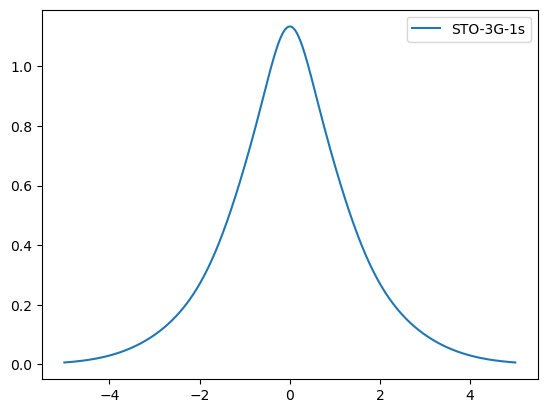

In [3]:
H_1s_alpha = STO_3G['1s']['alpha']
H_1s_coeff = STO_3G['1s']['coeff']
x = np.linspace(-5, 5, 1000)
y = np.zeros_like(x)
for i in range(len(H_1s_alpha)):
    y += H_1s_coeff[i] * np.exp(-H_1s_alpha[i] * x**2)
plt.plot(x, y, label='STO-3G-1s')
plt.legend()
plt.show()

## 利用RHF计算H2体系单点能

首先我们选取两个H原子，分别位于x轴上的-0.5和0.5处，然后我们使用RHF方法计算H2体系的单点能，具体的理论分析可以参考pdf。

要计算单点能，首先需要构建基组，然后计算双电子积分，构建Fock矩阵，迭代求解RHF方程，最后计算单点能。

基组一共有4个，分别是位于-0.5和0.5处的两个H原子的1s和2s轨道，我们需要计算的双电子积分有16个，分别是1s-1s, 1s-2s, 2s-1s, 2s-2s的重叠积分，动能积分，核-电子吸引积分和双电子排斥积分。

随后便是选择初猜密度矩阵，迭代求解RHF方程，最后计算单点能，具体的实现可以见main.py。

In [4]:
R = 1
H1 = np.array([R/2,0,0])
H2 = np.array([-R/2,0,0])

STO_1s = STO_3G['1s']
STO_2s = STO_3G['2s']

alpha = [STO_1s['alpha'], STO_2s['alpha']]
coeff = [STO_1s['coeff'], STO_2s['coeff']]

basis_set = Get_basis_set(H1,H2,alpha,coeff)
E,Coeff_matrix,P_matrix = Iteration(basis_set, H1, H2)
E += 1/R
print("距离为1时，H2总能量为",E)

距离为1时，H2总能量为 -1.0694147834420167


## 结构优化

对于给定的R，我们不仅可以求出H2体系的单点能，还能求出其能量对R的导数，这样我们就可以通过优化R来得到H2体系的最稳定结构，这里使用的是数值求导的方法，具体的实现可以见main.py。

In [5]:
# H2 结构优化部分
H2_initial = 1.3
# 三个参数代表: 1.数值梯度计算的h 2.初始猜测值 3.梯度下降的步长,返回列表为结构优化每一步H2的值，最后一个值为最优值  
H2_optimized =  Stucture_optimization(0.01,H2_initial,0.1)

Optimization step: 1 Current distance: 1.3042241787195419 Current energy: -1.1179865863894383
Optimization step: 2 Current distance: 1.3082219978387466 Current energy: -1.1181378524741854
Optimization step: 3 Current distance: 1.3120085714604102 Current energy: -1.1182725613875362
Optimization step: 4 Current distance: 1.315597698327371 Current energy: -1.118392675966163
Optimization step: 5 Current distance: 1.3190020086530962 Current energy: -1.1184998987645849
Optimization step: 6 Current distance: 1.3222330908989022 Current energy: -1.1185957111170093
Optimization step: 7 Current distance: 1.325301601709944 Current energy: -1.1186814055821483
Optimization step: 8 Current distance: 1.3282173616362547 Current energy: -1.118758113023534
Optimization step: 9 Current distance: 1.330989438798098 Current energy: -1.1188268253160945
Optimization step: 10 Current distance: 1.333626222281341 Current energy: -1.118888414467838
Optimization step: 11 Current distance: 1.3361354867460506 Current

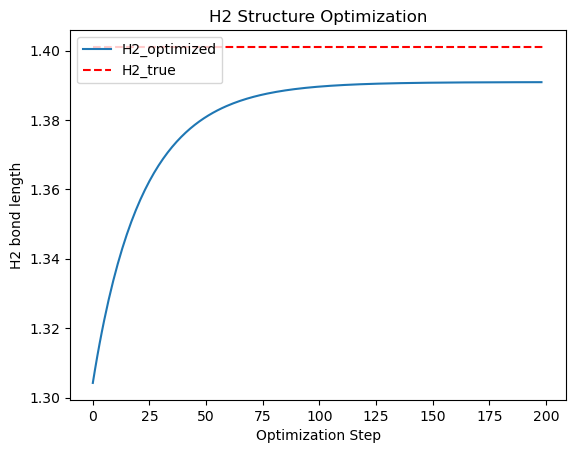

In [6]:
# 可以发现最后结果接近实验值
plt.plot(H2_optimized, label='H2_optimized')
plt.hlines(0.7414/0.529177210903, 0, len(H2_optimized), colors = "r", linestyles = "dashed", label='H2_true')
plt.title('H2 Structure Optimization')
plt.xlabel('Optimization Step')
plt.ylabel('H2 bond length')
plt.legend()
plt.show()

## 最优结构单点能计算和布居分析

最优结构选择的是键长为1.401。此外，Hartree-Fock计算不仅能拿到单点能，还能拿到轨道系数，从而可以计算出电子的布居，这里我们计算了H2体系的电荷分布和键级，具体的理论参见教科书。

In [7]:
# H2 能量计算部分
born_to_angstrom = 0.529177210903

RH = 0.7414/born_to_angstrom  #使用实验值
H1 = np.array([RH/2,0,0])
H2 = np.array([-RH/2,0,0])


# 输入H2坐标，生成基组，这里使用的为STO-3G基组，基组大小为4,(1s+2s)*2
basis_set = Get_basis_set(H1,H2,alpha,coeff)
E,Coeff_matrix,P_matrix = Iteration(basis_set, H1, H2)
E += 1/RH
print("Energy:",E)

# 布居分析

Charge = Mulliken_population(basis_set,P_matrix,H1,H2,1,1)
print("Mulliken population of H1 and H2:",Charge["Nuc1"]["Charge"],Charge["Nuc2"]["Charge"])

print("Bond valence of H1 and H2:",Charge["Bond"])


Energy: -1.1193907736813191
Mulliken population of H1 and H2: -1.1102230246251565e-15 -1.1102230246251565e-15
Bond valence of H1 and H2: 1.0000000000000022


## 绘制结果

这里我们将上述的结果绘制成二维投影图，分别画出了H2体系的电荷分布，成键轨道波函数和反键轨道波函数。

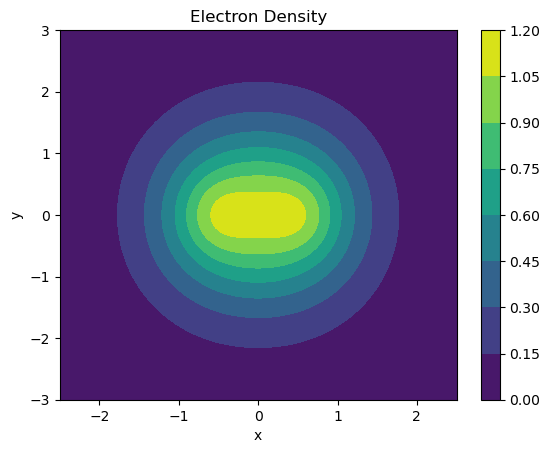

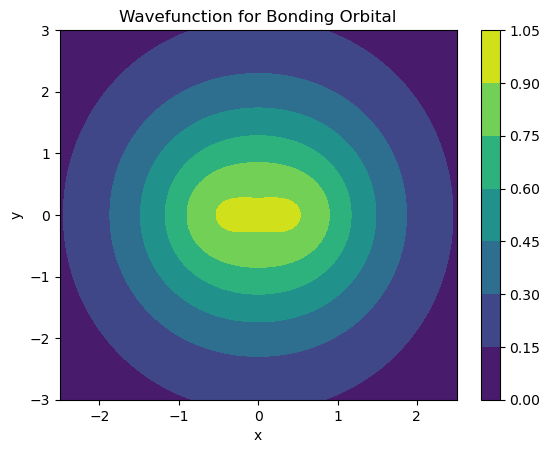

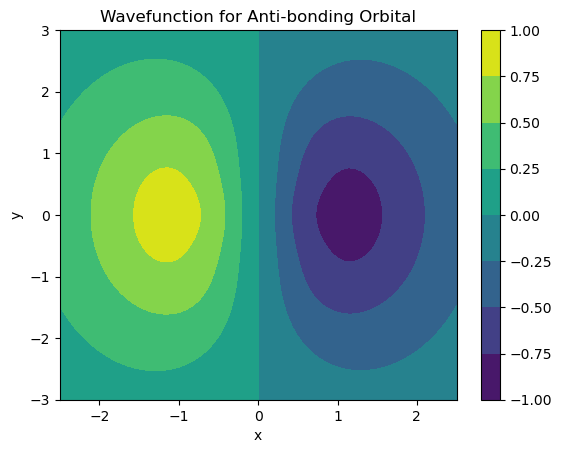

In [8]:
# 电子密度分析
x,y = np.linspace(-3,3,100),np.linspace(-2.5,2.5,100)
X,Y = np.meshgrid(x,y)
D = np.zeros_like(X)
for i in range(len(x)):
    for j in range(len(y)):
        D[i][j] = Density([x[i],y[j],0],basis_set,P_matrix)

plt.contourf(Y,X,D)
plt.colorbar()
plt.title('Electron Density')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## 波函数分析
W_BO = np.zeros_like(X)
for i in range(len(x)):
    for j in range(len(y)):
        W_BO[i][j] = Wavefunction([x[i],y[j],0],basis_set,Coeff_matrix,index=0)

plt.contourf(Y,X,W_BO)
plt.colorbar()
plt.title('Wavefunction for Bonding Orbital')
plt.xlabel('x')
plt.ylabel('y')

plt.show()


W_AO = np.zeros_like(X)
for i in range(len(x)):
    for j in range(len(y)):
        W_AO[i][j] = Wavefunction([x[i],y[j],0],basis_set,Coeff_matrix,index=1)

plt.contourf(Y,X,W_AO)
plt.colorbar()
plt.title('Wavefunction for Anti-bonding Orbital')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Post-HF方法和HF对比

最后这里我们使用了Restricted-Hartree-Fock(RHF)方法和Post-HF方法（MP2/CID）计算H2体系的解离能曲线。

如果只使用RHF方法解离能，在无穷远极限情况下其会得到错误的结果，而CID方法(对H2-1s轨道情况为Full-CI)则是精确的，MP2则会有些许改进，但仍无法得到正确的解离能，具体的推导见教科书。

In [9]:
# 绘制解离曲线(CID修正后)
R,E_CID = Decompositon_Curve_CID(start=0.3,end=6.0,points=300)
R,E_HF = Decompositon_Curve(start=0.3,end=6.0,points=300)
R,E_MP2 = Decompositon_Curve_MP2(start=0.3,end=6.0,points=300)
# np.savetxt('Energy_curve_cid.txt',np.array([R,E_CID]).T)
# np.savetxt('Energy_curve.txt',np.array([R,E_HF]).T)
# np.savetxt('Energy_curve_mp2.txt',np.array([R,E_MP2]).T)
# E_CID = np.loadtxt('Energy_curve_cid.txt')[:,1]
# E_HF = np.loadtxt('Energy_curve.txt')[:,1]
# E_MP2 = np.loadtxt('Energy_curve_mp2.txt')[:,1]
# R = np.loadtxt('Energy_curve_cid.txt')[:,0]


In [13]:
E_CID = np.array(E_CID)
E_HF = np.array(E_HF)
E_MP2 = np.array(E_MP2)

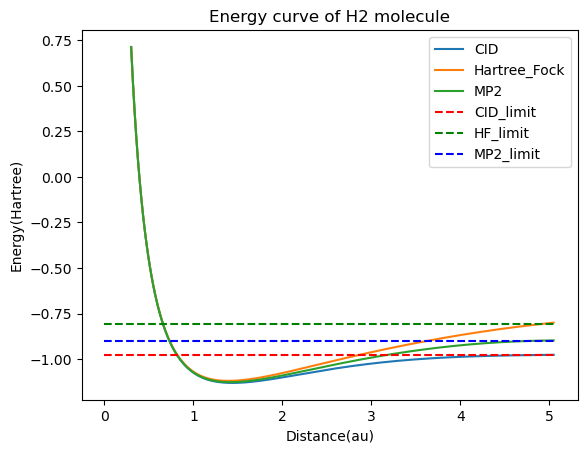

<Figure size 640x480 with 0 Axes>

In [14]:

end = 250
cpoints = 20
plt.plot(R[:end],E_CID[:end],label="CID")
CID_ave = np.mean(E_CID[end-cpoints:end])
HF_ave = np.mean(E_HF[end-cpoints:end])
MP2_ave = np.mean(E_MP2[end-cpoints:end])
plt.plot(R[:end],E_HF[:end],label="Hartree_Fock")
plt.plot(R[:end],E_MP2[:end],label="MP2")

plt.xlabel('Distance(au)')
plt.ylabel('Energy(Hartree)')
plt.title('Energy curve of H2 molecule')

plt.hlines(CID_ave, 0, R[end], colors = "r", linestyles = "dashed", label='CID_limit')
plt.hlines(HF_ave, 0, R[end], colors = "g", linestyles = "dashed", label='HF_limit')
plt.hlines(MP2_ave, 0, R[end], colors = "b", linestyles = "dashed", label='MP2_limit')

plt.legend()
plt.show()
plt.savefig('Energy_curve.png')

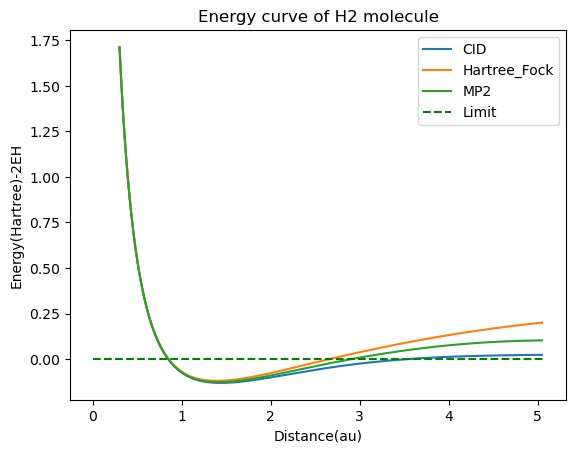

In [15]:
# 单个H原子能量为-0.5(Hartree)，所以无穷远H2的基态能量为-1
EH = -1
end = 250
cpoints = 20
plt.plot(R[:end],E_CID[:end]-EH,label="CID")
plt.plot(R[:end],E_HF[:end]-EH,label="Hartree_Fock")
plt.plot(R[:end],E_MP2[:end]-EH,label="MP2")
plt.xlabel('Distance(au)')
plt.ylabel('Energy(Hartree)-2EH')
plt.title('Energy curve of H2 molecule')
plt.hlines(0, 0, R[end], colors = "g", linestyles = "dashed", label='Limit')
plt.legend()
plt.show()

不难发现，在无穷远处，只有CID的结果是正确的。